In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/letters-dataset-emnist/emnist-letters-test-labels-idx1-ubyte
/kaggle/input/letters-dataset-emnist/emnist-letters-train-labels-idx1-ubyte
/kaggle/input/letters-dataset-emnist/emnist-letters-test-images-idx3-ubyte
/kaggle/input/letters-dataset-emnist/emnist-letters-train-images-idx3-ubyte
/kaggle/input/csv-dataset-letters-emnist/emnist_letters_dataset.csv
/kaggle/input/colored-mnist-and-uncolored-alphabets/colored_rgb_mnist_train.npz
/kaggle/input/colored-mnist-and-uncolored-alphabets/colored_rgb_mnist_test.npz
/kaggle/input/gz-emnist-letters/emnist-letters-test-labels-idx1-ubyte
/kaggle/input/gz-emnist-letters/emnist-letters-train-labels-idx1-ubyte
/kaggle/input/gz-emnist-letters/emnist-letters-test-images-idx3-ubyte
/kaggle/input/gz-emnist-letters/emnist-letters-train-images-idx3-ubyte


In [25]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [27]:
class AEStyleTransfer(nn.Module):
    def __init__(self, dropout_prob=0.01):
        super(AEStyleTransfer, self).__init__()

        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, 
                                        stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(16, 24, kernel_size=3, 
                                        stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(24 * 7 * 7, 24) 

        # Dropout layers
        self.dropout = nn.Dropout(p=self.dropout_prob)  # Add dropout layer

        # Decoder layers
        self.decoder_linear = nn.Linear(24, 24* 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(24, 16, 
                                                kernel_size=3,stride=2, 
                                                padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(16, 3, 
                                                kernel_size=3, stride=2, 
                                                padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = x.reshape(-1, 24 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.reshape(-1, 24, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0, 1) # Clamp output
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Let's download E-mnist dataset

In [28]:
import os
import numpy as np
import torch
from torchvision.transforms import ToTensor
import gzip

In [29]:
# def load_emnist_data(file_path_images, file_path_labels):
#     with gzip.open(file_path_images, 'rb') as f_images, gzip.open(file_path_labels, 'rb') as f_labels:
#         # Read the magic number and the number of images
#         magic_number_images = int.from_bytes(f_images.read(4), 'big')
#         num_images = int.from_bytes(f_images.read(4), 'big')
#         # Read the dimensions of each image
#         rows = int.from_bytes(f_images.read(4), 'big')
#         cols = int.from_bytes(f_images.read(4), 'big')
#         # Read the image data
#         image_data = np.frombuffer(f_images.read(), dtype=np.uint8)
#         # Reshape the image data to 2D array
#         images = image_data.reshape(num_images, rows, cols)

#         # Read the magic number and the number of labels
#         magic_number_labels = int.from_bytes(f_labels.read(4), 'big')
#         num_labels = int.from_bytes(f_labels.read(4), 'big')
#         # Read the label data
#         label_data = np.frombuffer(f_labels.read(), dtype=np.uint8)

#     assert num_images == num_labels, "Number of images and labels don't match"
    
#     return images, label_data

In [30]:
import numpy as np

def load_emnist_data(file_path_images, file_path_labels):
    with open(file_path_images, 'rb') as f_images, open(file_path_labels, 'rb') as f_labels:
        # Read the magic number and the number of images
        magic_number_images = int.from_bytes(f_images.read(4), 'big')
        num_images = int.from_bytes(f_images.read(4), 'big')
        # Read the dimensions of each image
        rows = int.from_bytes(f_images.read(4), 'big')
        cols = int.from_bytes(f_images.read(4), 'big')
        # Read the image data
        image_data = np.frombuffer(f_images.read(), dtype=np.uint8)
        # Reshape the image data to 2D array
        images = image_data.reshape(num_images, rows, cols)

        # Read the magic number and the number of labels
        magic_number_labels = int.from_bytes(f_labels.read(4), 'big')
        num_labels = int.from_bytes(f_labels.read(4), 'big')
        # Read the label data
        label_data = np.frombuffer(f_labels.read(), dtype=np.uint8)

    assert num_images == num_labels, "Number of images and labels don't match"
    
    return images, label_data

In [31]:
# Paths to the EMNIST image and label files
file_path_train_images = "/kaggle/input/gz-emnist-letters/emnist-letters-train-images-idx3-ubyte"
file_path_train_labels = "/kaggle/input/gz-emnist-letters/emnist-letters-train-labels-idx1-ubyte"
file_path_test_images = "/kaggle/input/gz-emnist-letters/emnist-letters-test-images-idx3-ubyte"
file_path_test_labels = "/kaggle/input/gz-emnist-letters/emnist-letters-test-labels-idx1-ubyte"

# Load train and test data
train_images, train_labels = load_emnist_data(file_path_train_images, file_path_train_labels)
test_images, test_labels = load_emnist_data(file_path_test_images, file_path_test_labels)

# Verify the shapes of the loaded data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (124800, 28, 28)
Train labels shape: (124800,)
Test images shape: (20800, 28, 28)
Test labels shape: (20800,)


In [32]:
import string

def convert_numeric_to_alphabetic_labels(numeric_labels):
    alphabet = string.ascii_lowercase
    alphabetic_labels = [alphabet[label - 1] for label in numeric_labels]  # Adjusting for 1-based indices
    return alphabetic_labels

# Usage example:
train_labels_alphabets = convert_numeric_to_alphabetic_labels(train_labels)
test_labels_alphabets = convert_numeric_to_alphabetic_labels(test_labels)

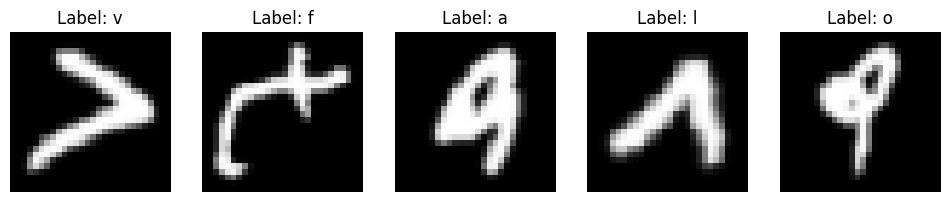

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_images(images, labels, num_images=5):
    assert len(images) == len(labels), "Number of images and labels must be the same"
    num_total_images = len(images)
    indices = np.random.choice(num_total_images, size=num_images, replace=False)

    plt.figure(figsize=(12, 6))
    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f"Label: {labels[index]}")
        plt.axis('off')
    plt.show()

# Usage example:
plot_random_images(test_images, test_labels_alphabets)

In [34]:
def resize_and_expand(uncolored_X):
  # Reshape uncolored images to (: 28, 28, 1)
  uncolored_X_resized = uncolored_X.reshape(-1, 28, 28, 1)
  
  # Expand single channel to three channels
  uncolored_X_expanded = np.repeat(uncolored_X_resized, 3, axis=-1)
  return uncolored_X_expanded


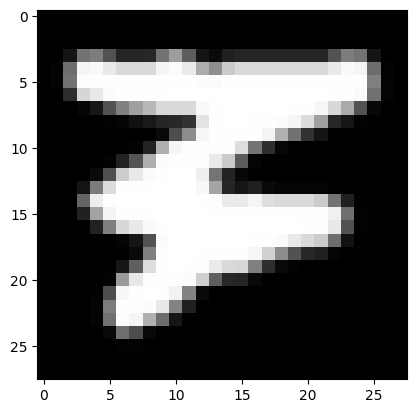

In [35]:
uncolored_X_train_expanded = resize_and_expand(train_images)
plt.imshow(uncolored_X_train_expanded[0])

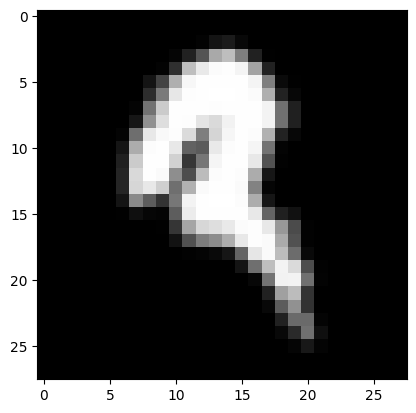

In [36]:
uncolored_X_test_expanded = resize_and_expand(test_images)
plt.imshow(uncolored_X_test_expanded[0])

In [37]:
np.shape(uncolored_X_train_expanded)

(124800, 28, 28, 3)

In [38]:
colored_rgb_train = np.load("/kaggle/input/colored-mnist-and-uncolored-alphabets/colored_rgb_mnist_train.npz")
colored_rgb_test = np.load("/kaggle/input/colored-mnist-and-uncolored-alphabets/colored_rgb_mnist_test.npz")


colored_rgb_X_train = colored_rgb_train["images"]
colored_rgb_X_test = colored_rgb_test["images"]

In [39]:
def check_min_and_max(data_in):
    print(f"max is {np.max(data_in)} and min is {np.min(data_in)}")

In [40]:
check_min_and_max(colored_rgb_X_train)
check_min_and_max(uncolored_X_test_expanded)

max is 1.0 and min is 0.0
max is 255 and min is 0


In [41]:
def normalize_between_0_and_1(array):
    """
    Normalize the input array between 0 and 1.
    
    Parameters:
        array (numpy.ndarray): Input array to be normalized.
        
    Returns:
        numpy.ndarray: Normalized array.
    """
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array


In [42]:
# Normalize the datasets
# # Convert the datasets to float32 before normalization
uncolored_X_train_expanded = uncolored_X_train_expanded.astype(np.float32)
uncolored_X_test_expanded = uncolored_X_test_expanded.astype(np.float32)
colored_rgb_X_train = colored_rgb_X_train.astype(np.float32)
colored_rgb_X_test = colored_rgb_X_test.astype(np.float32)

# # Normalize the datasets
uncolored_X_train_expanded=normalize_between_0_and_1(uncolored_X_train_expanded)
uncolored_X_test_expanded = normalize_between_0_and_1(uncolored_X_test_expanded)

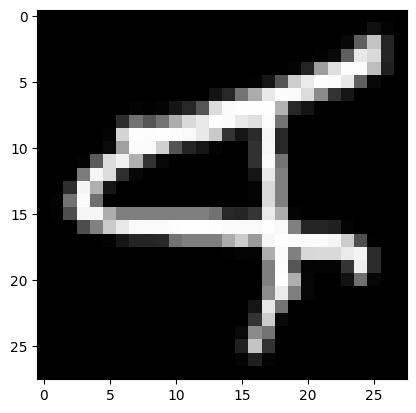

In [43]:
plt.imshow(uncolored_X_test_expanded[4])

In [44]:
# Concatenate uncolored and colored data and labels
mixed_X_train = np.concatenate((uncolored_X_train_expanded[:60000],
                                colored_rgb_X_train), axis=0)
mixed_X_test = np.concatenate((uncolored_X_test_expanded, colored_rgb_X_test)
                             ,axis=0)

mixed_X_train.shape, mixed_X_test.shape

((120000, 28, 28, 3), (30800, 28, 28, 3))

Create dataloaders

In [45]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Convert NumPy arrays to PyTorch tensors
mixed_X_train_tensor = torch.tensor(mixed_X_train)
mixed_X_test_tensor = torch.tensor(mixed_X_test)

# Permute the mixed_X_train and mixed_X_test tensors
mixed_X_train_permuted = mixed_X_train_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension
mixed_X_test_permuted = mixed_X_test_tensor.permute(0, 3, 1, 2)  # earlier channels are the last dimension

# Create a TensorDataset for train and test data
train_dataset = TensorDataset(mixed_X_train_permuted)
test_dataset = TensorDataset(mixed_X_test_permuted)

# Split the train dataset into train and validation datasets
train_indices, val_indices = train_test_split(range(len(train_dataset)),
                                              test_size=0.1, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Define batch size
batch_size = 64

# Create DataLoader objects
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

AE style transfer OOD check

In [47]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class AEStyleTransfer(nn.Module):
    def __init__(self, dropout_prob=0.01):
        super(AEStyleTransfer, self).__init__()

        self.dropout_prob = dropout_prob

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 16, kernel_size=3, 
                                        stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(16, 24, kernel_size=3, 
                                        stride=2, padding=1)  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(24 * 7 * 7, 24) 

        # Dropout layers
        self.dropout = nn.Dropout(p=self.dropout_prob)  # Add dropout layer

        # Decoder layers
        self.decoder_linear = nn.Linear(24, 24* 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(24, 16, 
                                                kernel_size=3,stride=2, 
                                                padding=1, output_padding=1)  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(16, 3, 
                                                kernel_size=3, stride=2, 
                                                padding=1, output_padding=1)  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = x.reshape(-1, 24 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.reshape(-1, 24, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.decoder_conv2(x)
        x = torch.relu(x)
        x = torch.clamp(x, 0, 1) # Clamp output
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms.functional import to_tensor
from tqdm import tqdm

def train_and_evaluate(autoencoder, train_loader, val_loader,
                       num_epochs=10, learning_rate=1e-3, weight_decay=0.001,
                       step_size_scheduler=5,gamma_scheduler=0.5,
                       print_epoch=10, device='cuda' if torch.cuda.is_available() else 'cpu'):

    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=step_size_scheduler,
                                          gamma= gamma_scheduler)  # Learning rate scheduler

    autoencoder.to(device)  # Move model to device

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        train_loss = 0.0
        val_loss = 0.0

        # Training
        autoencoder.train()
        for data in train_loader:
            inputs = data[0] # extract the data
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = autoencoder(inputs)

            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        autoencoder.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs = data[0] # extract the data
                inputs = inputs.to(device)

                outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)

                val_loss += loss.item()

        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Print losses
        if (epoch + 1) % print_epoch == 0:
            print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.9f}, Val Loss: {val_loss:.9f}")

    return train_losses, val_losses



In [49]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [50]:
def plot_images_test_AE(actual_images, reconstructed_images):
    fig, axes = plt.subplots(2, len(actual_images), figsize=(len(actual_images) * 2, 4))
    for i in range(len(actual_images)):
        axes[0, i].imshow(np.transpose(actual_images[i].numpy(), (1, 2, 0)).astype(np.float32))  # Transpose to (28, 28, 3) format for actual images
        axes[0, i].axis('off')
        axes[0, i].set_title('True')  # Add title for true data
        axes[1, i].imshow(np.transpose(reconstructed_images[i].numpy(), (1, 2, 0)).astype(np.float32))  # Transpose to (28, 28, 3) format for reconstructed images
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')  # Add title for reconstructed data
    plt.show()


def test_model_ae(autoencoder, test_loader, num_images=8, device='cuda' if torch.cuda.is_available() else 'cpu'):
    autoencoder.eval()
    actual_images = []
    reconstructed_images = []
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]  # extract the data
            inputs = inputs.to(device)

            # Encode and decode the images
            outputs = autoencoder(inputs)
            actual_images.extend(inputs[:num_images].cpu())  # Select first num_images actual images
            reconstructed_images.extend(outputs[:num_images].cpu())  # Select first num_images reconstructed images

            if len(actual_images) >= num_images:
                break

    plot_images_test_AE(actual_images, reconstructed_images)

In [51]:
# instantiate the model
autoencoder_mixed_mnist=AEStyleTransfer(dropout_prob=0.01)

# train
train_losses, val_losses = train_and_evaluate(autoencoder_mixed_mnist,
                                              train_loader, val_loader,learning_rate=1e-3,
                                              weight_decay=0.0001,
                                              step_size_scheduler=10,
                                              gamma_scheduler=0.6,
                                              num_epochs=100, print_epoch=10)

Epochs:  10%|█         | 10/100 [01:00<08:46,  5.85s/it]


Epoch [10/100], Train Loss: 1419.458724035, Val Loss: 1337.756329151


Epochs:  20%|██        | 20/100 [01:59<07:47,  5.84s/it]


Epoch [20/100], Train Loss: 1334.141464595, Val Loss: 1264.010891529


Epochs:  30%|███       | 30/100 [02:57<06:49,  5.85s/it]


Epoch [30/100], Train Loss: 1298.437078178, Val Loss: 1228.591539099


Epochs:  40%|████      | 40/100 [03:55<05:53,  5.90s/it]


Epoch [40/100], Train Loss: 1279.196746537, Val Loss: 1207.668008683


Epochs:  50%|█████     | 50/100 [04:54<04:55,  5.90s/it]


Epoch [50/100], Train Loss: 1267.657646215, Val Loss: 1198.328426280


Epochs:  60%|██████    | 60/100 [05:55<04:07,  6.19s/it]


Epoch [60/100], Train Loss: 1260.835642593, Val Loss: 1193.196464701


Epochs:  70%|███████   | 70/100 [06:57<03:05,  6.18s/it]


Epoch [70/100], Train Loss: 1256.922370187, Val Loss: 1189.203987284


Epochs:  80%|████████  | 80/100 [07:59<02:05,  6.26s/it]


Epoch [80/100], Train Loss: 1254.053440582, Val Loss: 1186.480706398


Epochs:  90%|█████████ | 90/100 [09:02<01:01,  6.20s/it]


Epoch [90/100], Train Loss: 1252.228884186, Val Loss: 1185.534058916


Epochs: 100%|██████████| 100/100 [10:03<00:00,  6.04s/it]


Epoch [100/100], Train Loss: 1252.003941974, Val Loss: 1185.056635918


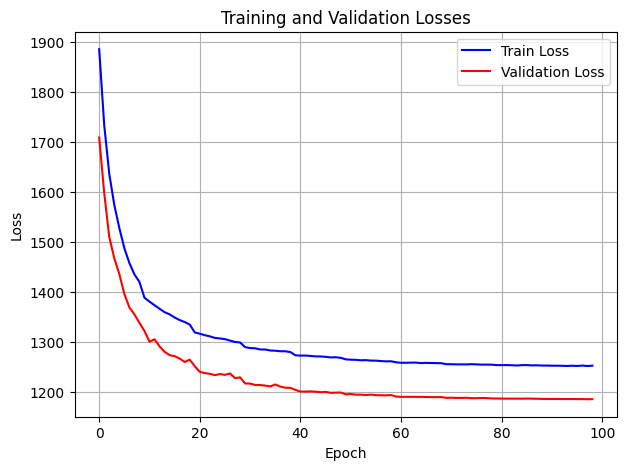

<Figure size 640x480 with 0 Axes>

In [67]:
# Usage example:
plot_losses(train_losses[1:], val_losses[1:])
plt.savefig("AE_EMNIST_COLORED_MNIST_loss.jpeg")
plt.savefig("AE_EMNIST_COLORED_MNIST_loss.pdf")

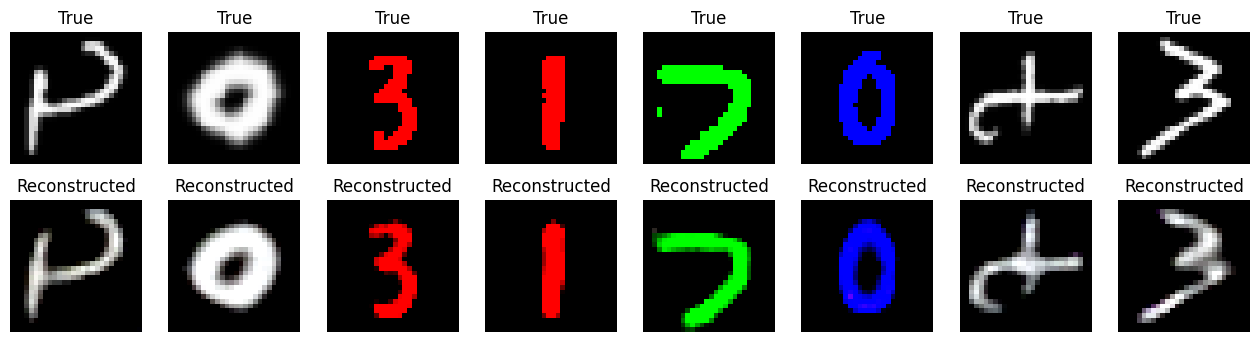

In [65]:
# plotting some images from test dataset
test_model_ae(autoencoder_mixed_mnist, test_loader)

In [68]:
checkpoint_path = 'checkpoint_AE_EMNIST_STYLE_TRANSFER.pth'
torch.save({
    'model': AEStyleTransfer(dropout_prob=0.01),
    'model_state_dict': autoencoder_mixed_mnist.state_dict(),
    
}, checkpoint_path)

In [ ]:
#/kaggle/working/checkpoint_AE_EMNIST_STYLE_TRANSFER.pth

In [71]:
### checking the loaded model
checkpoint_path='/kaggle/working/checkpoint_AE_EMNIST_STYLE_TRANSFER.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Access the model from the loaded checkpoint
model_in = checkpoint['model']

# Optionally, load the state dictionary to the model
model_in.load_state_dict(checkpoint['model_state_dict'])
model_in.to(device)

AEStyleTransfer(
  (encoder_conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_conv2): Conv2d(16, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (encoder_linear): Linear(in_features=1176, out_features=24, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (decoder_linear): Linear(in_features=24, out_features=1176, bias=True)
  (decoder_conv1): ConvTranspose2d(24, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (decoder_conv2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

Create the encodings for the train and test set:

### Let's see the OOD style transfer

In [78]:
encodings_train_mixed_emnist=autoencoder_mixed_mnist.encoder(mixed_X_train_permuted.to(device))
encodings_test_mixed_emnist=autoencoder_mixed_mnist.encoder(mixed_X_test_permuted.to(device))
encodings_train_mixed_emnist.shape,encodings_test_mixed_emnist.shape

(torch.Size([120000, 24]), torch.Size([30800, 24]))